# Conserved Flow SparseDream

## Intro
* **Date**: 12/17/2020
* **What**: This is another attempt at sparse coding and reconstruction that should hopefully result in more stable thresholds. Basically, instead of moving the neuron's threshold every iteration in response to its output (like Foldiak's network), this network move's neuron thresholds in order to ensure that the output charge of the sparse layer is some fixed fraction of the charge going in to the layer.
* **Why**: Just doing the Foldiak-style implementation of the sparsity threshold had some big issues.  Probably the biggest was that by itself, it didn't actually ensure that a certain number of neurons would fire for every input.  The behavior I saw was many neurons firing for a small portion of inputs.  The annoying thing is that nothing about the math actually makes a small portion of neurons fire for every input.  Anyway, I think that by essentially enforcing a conservation rule between the input and output, I can hopefully adjust the thresholds in a manner that ensures a small portion of neurons are firing for every input.  The other problem with the Foldiak neurons is that I had to make the learning constant on the threshold sparsity quite large for the network to become properly sparse.  Basically all that did was ensure that the same neuron wouldn't respond strongly to anything twice in a row.  Not even if it was the exact same input.  That's really not great, especially if your input a part of time-series data, or is smoothly changing.  The update rule on this network should be more stable, in the sense that neurons can literally fire forever on the same output and nothing will change.  In any event, that's the hope.
* **Hopes**: As I literally just said, the hope for this network is that the sparsity metric is more stable, and also ensure that a small number of neurons fire for ever input, rather than a large number of neurons firing for a small number of inputs.
* **Limitations**: I'm not 100% convinced that the features are actually going to be sparse.  I think they are, because the reconstruction rule does such a marvelous job at stabilizing outputs relative to inputs, but be that as it may, I certainly can't rule out literally everything breaking.  

## Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from scipy.special import expit as sig

(train_x, train_y), (test_x, test_y) = mnist.load_data()

m_flat_tr = train_x.reshape(train_x.shape[0], -1) / 255.0
m_flat_te = test_x.reshape(test_x.shape[0], -1) / 255.0 

m_tr_len, m_len = m_flat_tr.shape

def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()
    
def relu(x):
    return (abs(x) + x) / 2

<IPython.core.display.Javascript object>


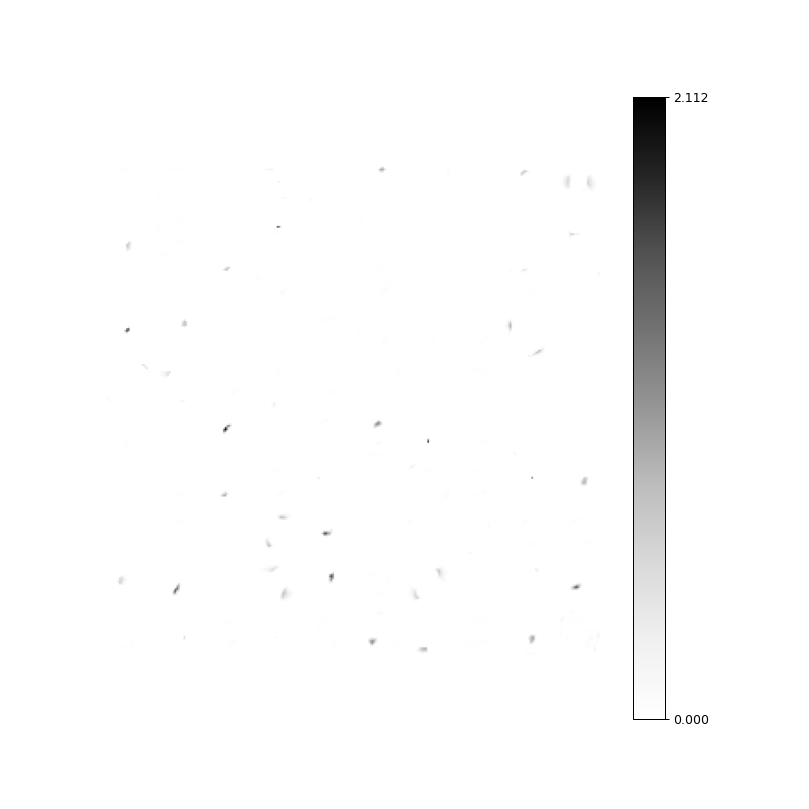

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1846.80it/s]


In [26]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 3000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

t = np.zeros((N, 1))
gamma = 0.001

frac = 0.2

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(tr_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        o = sig(w_v - t)
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        
        t += (np.sum(o) - frac * np.sum(v)) * o * gamma
        
    draw_weights(w, Kx, Ky, 28, fig)

# Analysis Dialog

Well, sparsity isn't the problem.  You know what?  I'm going to be more responsible and include statistics that represent how well the network is doing at its objectives.

<IPython.core.display.Javascript object>


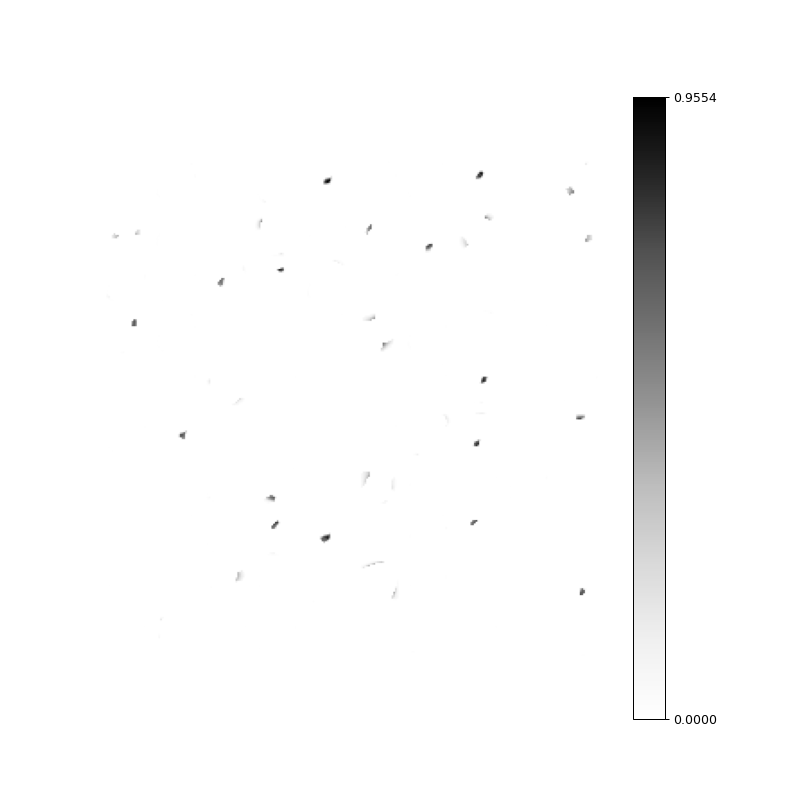

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1952.10it/s]


Mean reconstruction error:  815.8608336794325  Mean flow error:  14.660038458603765


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1980.33it/s]


Mean reconstruction error:  107.17229356513087  Mean flow error:  4.299765629235417


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2008.65it/s]


Mean reconstruction error:  92.60607578755982  Mean flow error:  3.2240941880786473


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2044.38it/s]


Mean reconstruction error:  85.74348257294841  Mean flow error:  3.750562038105681


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2044.36it/s]


Mean reconstruction error:  85.58106400488803  Mean flow error:  3.8219042156466223


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2026.14it/s]


Mean reconstruction error:  87.4222933087548  Mean flow error:  3.9852201464914967


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2029.65it/s]


Mean reconstruction error:  88.49934164120226  Mean flow error:  4.043099277873658


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2027.50it/s]


Mean reconstruction error:  89.65544697667158  Mean flow error:  4.086658613506451


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2034.71it/s]


Mean reconstruction error:  90.21153317092565  Mean flow error:  4.170425533860364


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1942.19it/s]


Mean reconstruction error:  91.40500022474144  Mean flow error:  4.268499673172133


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2081.15it/s]


Mean reconstruction error:  92.17990790437808  Mean flow error:  4.278307792097169


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2072.42it/s]


Mean reconstruction error:  93.38051913964915  Mean flow error:  4.277328395198166


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2010.64it/s]


Mean reconstruction error:  92.04607787749698  Mean flow error:  4.288484052034953


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1991.62it/s]


Mean reconstruction error:  92.3289845897345  Mean flow error:  4.291287840429636


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2025.00it/s]


Mean reconstruction error:  91.62530222752834  Mean flow error:  4.245861406040261


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2070.28it/s]


Mean reconstruction error:  92.17348118411759  Mean flow error:  4.283640379993646


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2006.27it/s]


Mean reconstruction error:  91.81208846687161  Mean flow error:  4.230993947870907


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2023.13it/s]


Mean reconstruction error:  91.97885504073541  Mean flow error:  4.290756989653095


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1988.65it/s]


Mean reconstruction error:  92.11417284078225  Mean flow error:  4.3394211901728115


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2030.95it/s]


Mean reconstruction error:  92.67794837600327  Mean flow error:  4.324052972489529


In [35]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 3000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

t = np.zeros((N, 1))
gamma = 0.0001

frac = 0.2

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(tr_len)]
    e_ac = []
    ef_ac = []
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        o = sig(w_v - t)
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        e_ac.append(np.sum(np.abs(e)))
        
        w += w * o * (e / mod_r).T * xi
        
        ef = (np.sum(o) - frac * np.sum(v))
        ef_ac.append(ef)
        
        t += (np.sum(o) - frac * np.sum(v)) * o * gamma
    print("Mean reconstruction error: ", np.mean(e_ac), " Mean flow error: ", np.mean(np.abs(ef_ac)))
    draw_weights(w, Kx, Ky, 28, fig)

Hmm.  That doesn't seem very good.  It's getting 92 pixels wrong on average?  Yikes.  I'm going to plot the weights, and then I'm going to do a couple reconstructions.

<IPython.core.display.Javascript object>


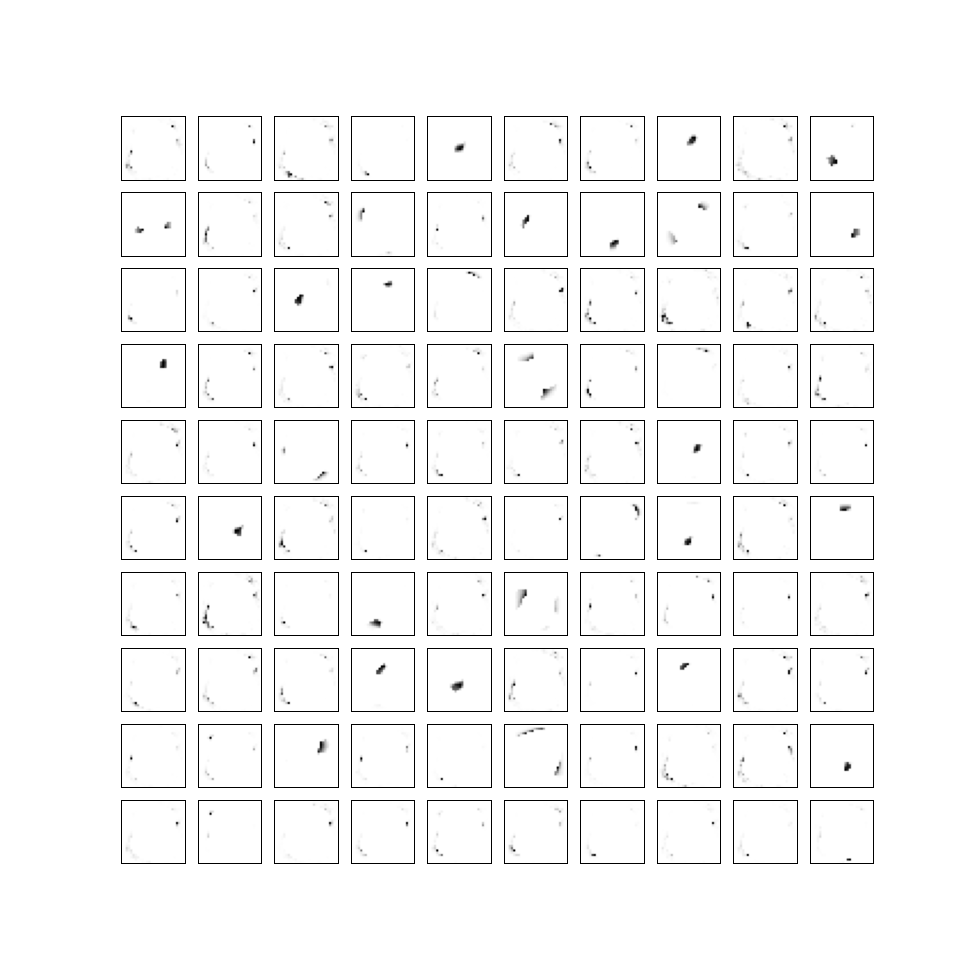

In [36]:
fig = plt.figure(figsize=(12, 12))

for x in range(Kx):
    for y in range(Ky):
        plt.subplot(Ky, Kx, 1 + x + (Kx * y))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(w[x + (Kx * y)].reshape(28, 28), cmap="Greys")
plt.show()

Hmm.  Yeah it just looks like most of the features aren't contributing at all.  Let's reconstruct.

<IPython.core.display.Javascript object>


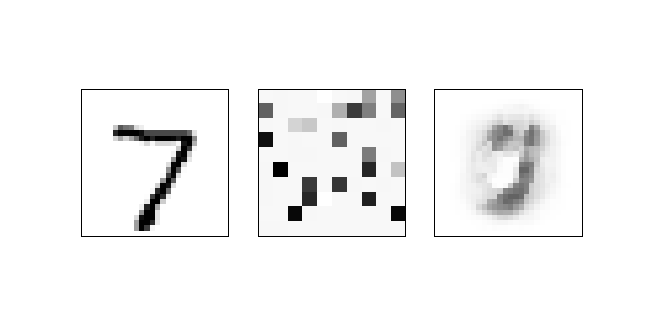

In [37]:
img_i = 0

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
o = sig(w_v - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(10, 10), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


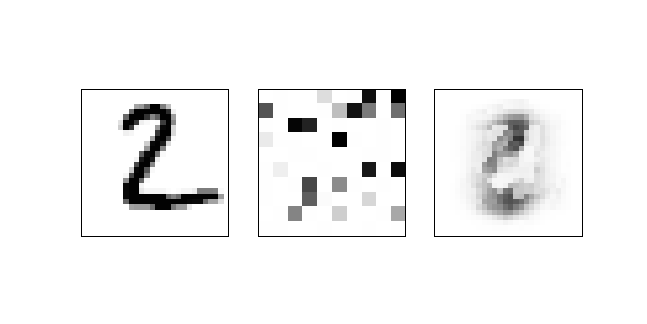

In [38]:
img_i = 1

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
o = sig(w_v - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(10, 10), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


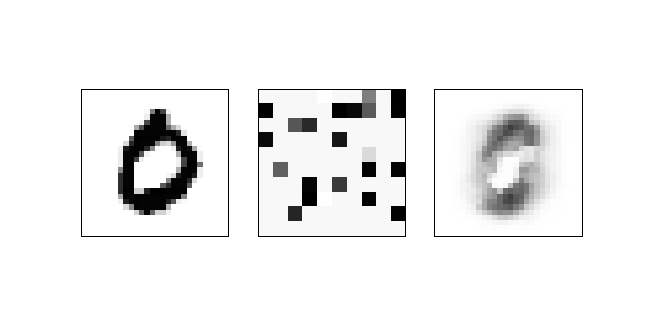

In [39]:
img_i = 3

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
o = sig(w_v - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(10, 10), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


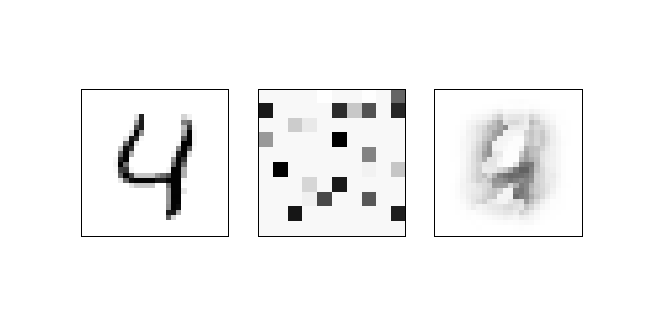

In [40]:
img_i = 4

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
o = sig(w_v - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(10, 10), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


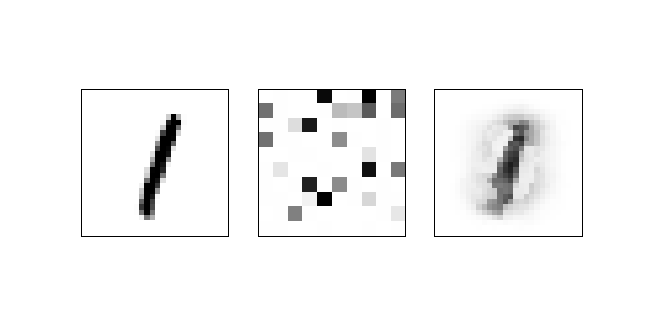

In [41]:
img_i = 5

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
o = sig(w_v - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(10, 10), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

Yikes that's bad.  Actually, before I work out, I'm going to significantly decrease the flow and see if that helps.

<IPython.core.display.Javascript object>


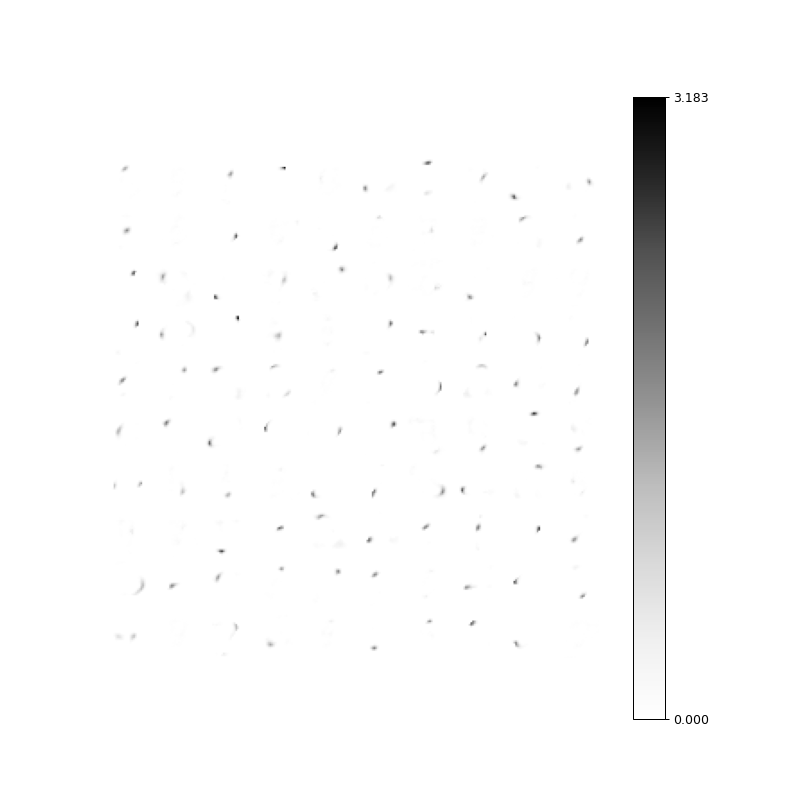

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1853.41it/s]


Mean reconstruction error:  816.0346199729191  Mean flow error:  27.92540781038751


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1866.36it/s]


Mean reconstruction error:  100.77491338817856  Mean flow error:  14.772081156668836


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1972.41it/s]


Mean reconstruction error:  80.35726985580607  Mean flow error:  10.835323515872641


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1968.81it/s]


Mean reconstruction error:  70.24096791509368  Mean flow error:  9.656473440422797


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2031.78it/s]


Mean reconstruction error:  65.992685733802  Mean flow error:  9.31232024841646


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2005.84it/s]


Mean reconstruction error:  64.19818582494518  Mean flow error:  9.006098011543266


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1842.52it/s]


Mean reconstruction error:  64.01675497554619  Mean flow error:  8.720795420086443


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1955.53it/s]


Mean reconstruction error:  64.67847814741855  Mean flow error:  8.353068270806364


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1902.52it/s]


Mean reconstruction error:  64.59647213214264  Mean flow error:  8.547189288625159


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1957.48it/s]


Mean reconstruction error:  63.464063820810715  Mean flow error:  8.941986755652605


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1971.52it/s]


Mean reconstruction error:  62.90538942314172  Mean flow error:  8.700992140084614


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1884.82it/s]


Mean reconstruction error:  62.46330330033349  Mean flow error:  8.348984098500551


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1945.67it/s]


Mean reconstruction error:  63.47668398899639  Mean flow error:  8.29213926198634


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2013.34it/s]


Mean reconstruction error:  63.54523852440655  Mean flow error:  8.471247975997782


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1880.67it/s]


Mean reconstruction error:  63.12684857666847  Mean flow error:  8.760356006931035


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1986.29it/s]


Mean reconstruction error:  61.12100876076206  Mean flow error:  8.64819538314966


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1945.97it/s]


Mean reconstruction error:  62.32532106497843  Mean flow error:  8.578189991246735


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1982.44it/s]


Mean reconstruction error:  61.42856956538721  Mean flow error:  8.227717715299203


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1941.14it/s]


Mean reconstruction error:  62.34595303923335  Mean flow error:  8.218315309461923


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1923.57it/s]


Mean reconstruction error:  63.176125988174675  Mean flow error:  8.085585065978716


In [51]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 3000

Kx = 10
Ky = 10
N = Kx * Ky
m_len = 28 * 28 
tr_len = 60000

prec = 1e-10

# Initialize feedforward synapses
w = np.random.uniform(0.1, 1, (N, m_len))
xi = 0.02

t = np.zeros((N, 1))
gamma = 0.0001

frac = 0.0001

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(tr_len)]
    e_ac = []
    ef_ac = []
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        o = sig(w_v - t)
        
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        e_ac.append(np.sum(np.abs(e)))
        
        w += w * o * (e / mod_r).T * xi
        
        ef = (np.sum(o) - frac * np.sum(v))
        ef_ac.append(ef)
        
        t += (np.sum(o) - frac * np.sum(v)) * o * gamma
    print("Mean reconstruction error: ", np.mean(e_ac), " Mean flow error: ", np.mean(np.abs(ef_ac)))
    draw_weights(w, Kx, Ky, 28, fig)

<IPython.core.display.Javascript object>


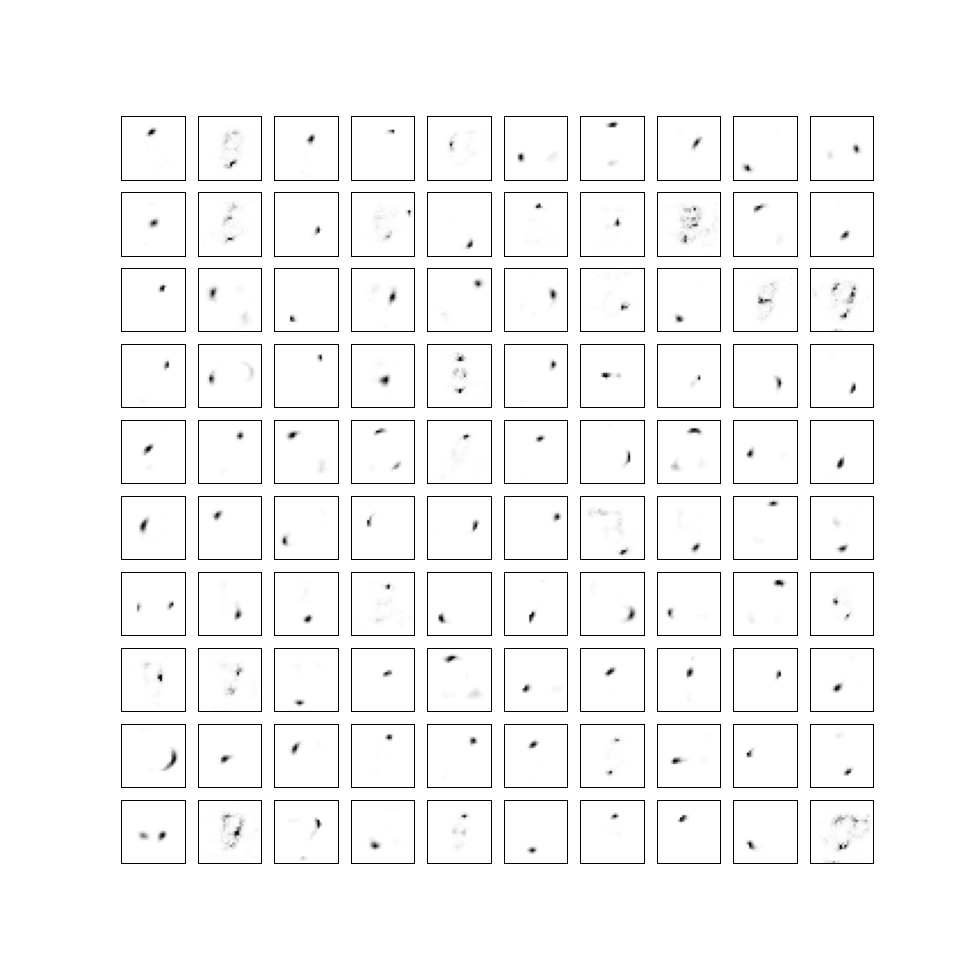

In [52]:
fig = plt.figure(figsize=(12, 12))

for x in range(Kx):
    for y in range(Ky):
        plt.subplot(Ky, Kx, 1 + x + (Kx * y))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(w[x + (Kx * y)].reshape(28, 28), cmap="Greys")
plt.show()

Hmm.  Yeah it just looks like most of the features aren't contributing at all.  Let's reconstruct.

<IPython.core.display.Javascript object>


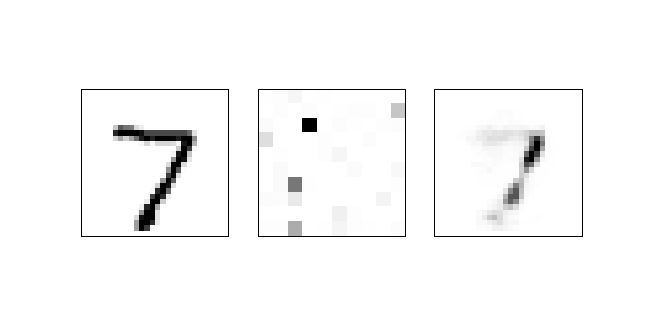

In [53]:
img_i = 0

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
o = sig(w_v - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(10, 10), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


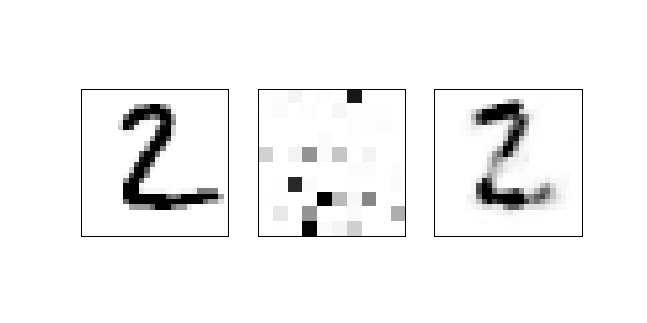

In [54]:
img_i = 1

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
o = sig(w_v - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(10, 10), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


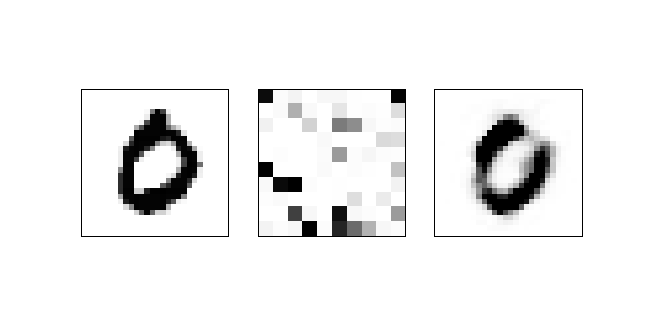

In [55]:
img_i = 3

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
o = sig(w_v - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(10, 10), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


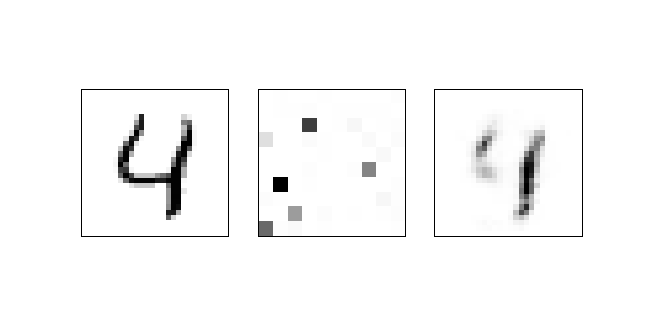

In [56]:
img_i = 4

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
o = sig(w_v - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(10, 10), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


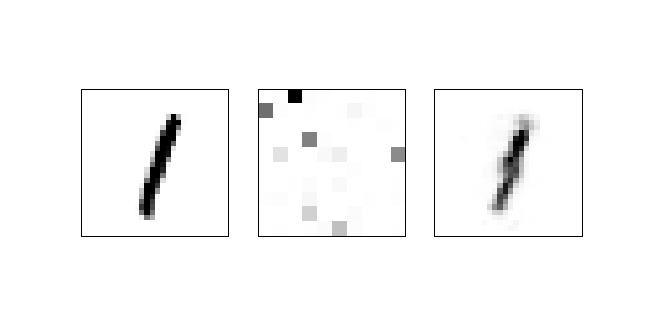

In [57]:
img_i = 5

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
o = sig(w_v - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(10, 10), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

Well, those bad bois sure as heck ain't sparse.  I'm going to workout, eat lunch, and then come back and figure this out.

Actually, after taking a very long walk, I think I've decided that this is kinda bust.  I'm just going to wrap it up.

## Conclusions

After walking and thinking about this, I've come to the conclusion that there's one fundamental difference between Olshausen's method of sparse coding and what I'm doing.  In Olshausen's model, there is no deterministic function for $\hat{a}$.  He basically does gradient descent to find $\hat{a}$ given the basis functions, and then he iterates on the basis vectors to make the reconstruction as good as possible.  That gives his model a *TON* of flexibility.  The network essentially recruits as many basis vectors as it needs to reconstruct the output, nothing more.  

I, on the other hand, have been attempting to find $\hat{a}$ from a deterministic function, mostly because it would be way faster.  That being said, I'm not really giving myself particularly good stuff to work with.  Meaning, I basically have a biased non-linearity.  That's not great.  Especially with this network, that's not great because the other outputs aren't even informing the selection of $\hat{a}$ (through things like lateral excitation or inhibition).  

I still definitely want a deterministic function that gives $\hat{a}$ directly from the inputs.  Gradient descent is just far too inefficient.  However, I need to give myself greater flexibility in how I calculate $\hat{a}$.  Thus, I think the thing to do is to bring in a neural network.  I literally need a function approximater, and there's no one who can do the job like an ANN. 

So yeah, I think that's going to be next experiment's problem.  

## Next steps

SparseDream, but modified.  Basically slap a one or two layer neural net in there to calculate $\hat{a}$, and then reconstruct.  I'm going to have to add all sorts of nonsense to the objective function to keep it from doing unholy things.

I actually think this is a pretty good idea.  